# Charge Resolution

This notebook explores the simple charge resolution for a single pixel with configuration parameters defined during a conversation with Rich, considering specifications for the final SST Camera design.

In [33]:
from sstcam_simulation import Camera, SSTCameraMapping, PhotoelectronSource, EventAcquisition
from CHECLabPy.utils.resolutions import ChargeResolution
from CHECLabPy.plotting.resolutions import ChargeResolutionPlotter
from sstcam_simulation.camera.spe import SiPMGentileSPE
from sstcam_simulation.camera.noise import GaussianNoise
from ctapipe.image.extractor import FixedWindowSum
from tqdm import tqdm, trange
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
# Define the camera
camera = Camera(
    mapping=SSTCameraMapping(n_pixels=1),  # Only need a single pixel
    continuous_readout_duration=128,  # Only need a single-waveform's worth of readout
    n_waveform_samples=128,
    photoelectron_spectrum=SiPMGentileSPE(opct=0.15),
    digitisation_noise=GaussianNoise(stddev=1/4)
)
n_pixels = camera.mapping.n_pixels
pixel_array = np.arange(n_pixels)
nsb_rate = 120
time = 30
extractor = FixedWindowSum(subarray=camera.ctapipe_subarray, peak_index=time, window_width=8, window_shift=3)
source = PhotoelectronSource(camera=camera)
acquisition = EventAcquisition(camera=camera)
charge_resolution = ChargeResolution(mc_true=True)

In [28]:
# Calculate pedestal
n_events = 100
charge_measured = np.zeros((n_events, camera.mapping.n_pixels))
for i in range(n_events):
    nsb = source.get_nsb(nsb_rate)
    readout = acquisition.get_continuous_readout(nsb)
    waveform = acquisition.get_sampled_waveform(readout)
    charge_measured[i] = waveform[:, 30:30+extractor.window_width.tel[1]].sum(1)
pedestal = charge_measured.mean()
print(pedestal)

1.1468035249807471


In [27]:
n_events = 100
for illumination in tqdm(np.logspace(0.1, 3, 100)):
    for iev in range(n_events):
        pe = source.get_uniform_illumination(time=time, illumination=illumination)
        nsb = source.get_nsb(nsb_rate)
        readout = acquisition.get_continuous_readout(pe+nsb)
        waveform = acquisition.get_sampled_waveform(readout)
        
        # Charge Extraction
        measured_charge = extractor(waveform, 1, 0)[0] - pedestal
        
        true_charge = pe.get_photoelectrons_per_pixel(n_pixels)
        charge_resolution.add(pixel_array, true_charge, measured_charge)

100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


In [29]:
df, _ = charge_resolution.finish()

In [30]:
def bin_dataframe(df, n_bins=40):
    true = df['true'].values
    min_ = true.min()
    max_ = (true.max() // 500 + 1) * 500
    bins = np.geomspace(0.1, max_, n_bins)
    bins = np.append(bins, 10**(np.log10(bins[-1]) + np.diff(np.log10(bins))[0]))
    df['bin'] = np.digitize(true, bins, right=True) - 1

    log = np.log10(bins)
    between = 10**((log[1:] + log[:-1]) / 2)
    edges = np.repeat(bins, 2)[1:-1].reshape((bins.size-1 , 2))
    edge_l = edges[:, 0]
    edge_r = edges[:, 1]
    df['between'] = between[df['bin']]
    df['edge_l'] = edge_l[df['bin']]
    df['edge_r'] = edge_r[df['bin']]

    return df

In [31]:
df = bin_dataframe(df, n_bins=40)

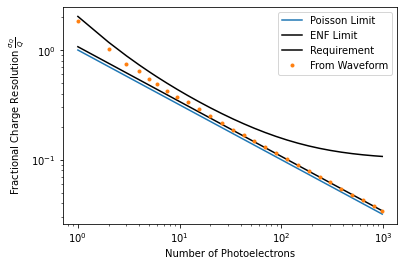

In [36]:
df_mean = df.groupby('bin').mean()
bin_ = df_mean.index
x = df_mean['true'].values
y = df_mean['charge_resolution'].values

poisson_limit = np.sqrt(x) / x
enf_limit = np.sqrt(camera.photoelectron_spectrum.excess_noise_factor * x) / x
requirement = ChargeResolutionPlotter.requirement(x)

plt.plot(x, poisson_limit, label="Poisson Limit")
plt.plot(x, enf_limit, label="ENF Limit", color='black')
plt.plot(x, requirement, label="Requirement", color='black')
plt.plot(x, y, '.', label="From Waveform")
plt.legend(loc="best")
plt.xlabel("Number of Photoelectrons")
plt.ylabel(r"Fractional Charge Resolution $\frac{{\sigma_Q}}{{Q}}$")
plt.xscale('log')
plt.yscale('log')